## Heckman two stage method demo

- Source: https://juliaeconomics.com/tag/heckman-correction/

In [13]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

### Utility functions

- **gen_population**: Generates single variate random population data given population size N and covariates beta
- **gen_sample**: Generates sample data given population data based on a biased selection policy
- **OLS**: Ordinary Least Squares linear regression on given X, Y
- **inverse_mills**: Inverse Mills Ratio

In [15]:
def gen_population(N, beta, debug=False):
    eps = np.random.normal(0.0, 1.0, N)
    X = np.random.randn(N)
    Y = beta[0] + beta[1] * X + eps
    population_data = pd.DataFrame({'Y' : Y, 'X' : X, 'eps' : eps})
    if debug: print('population data shape: (%d, %d)' % population_data.shape)
    return population_data

def gen_sample(population, debug=False):
    selected = population['X'] > population['eps']
    sample_data = pd.DataFrame({'Y' : population['Y'][selected], 'X' : population['X'][selected], 'eps' : population['eps'][selected]})
    if debug: print('sample data shape: (%d, %d)' % sample_data.shape)
    return sample_data

def OLS(Y, X):
    lr = LinearRegression()
    lr.fit(X, Y)
    return lr.intercept_[0], lr.coef_[0]

def inverse_mills(val):
    return -norm.pdf(val) / norm.cdf(val)

In [16]:
inverse_mills(0)

-0.79788456080286541

### Heckman Correction

In [17]:
def heckman(N, beta, debug=False):
    # Generate Data
    population_data = gen_population(N=N, beta=beta, debug=debug)
    sample_data = gen_sample(population=population_data, debug=debug)
    
    if debug:
        #Report Covariance of X and error term in population data
        cov_pop = np.cov((population_data['X'], population_data['eps']))[0,1]
        print('cov(X, eps) of population data: %0.4lf' % cov_pop)

        #Report Covariance of X and error term in sample data, see the difference, need to reduce that
        cov_sample = np.cov((sample_data['X'], sample_data['eps']))[0,1]
        print('cov(X, eps) of sample data: %0.4lf' % cov_sample)

    #Parameter estimation from original population data (should be close to original parameters)
    beta = OLS(population_data['Y'].values.reshape(-1,1), population_data['X'].values.reshape(-1,1))
    if debug: print('params (population): b0: %0.4lf, b1: %0.4lf' % (beta[0], beta[1]))

    #Parameter estimation from sample data without correction (likely to be far off from original parameters)
    beta_hat = OLS(sample_data['Y'].values.reshape(-1,1), sample_data['X'].values.reshape(-1,1))
    if debug: print('params (sample) before correction => b0: %0.4lf, b1: %0.4lf' % (beta_hat[0], beta_hat[1]))
    
    #Parameter estimation from sample data with correction (likely to be close to original parameters)
    sample_data['im'] = inverse_mills(sample_data['X'])
    beta_hat = OLS(sample_data['Y'].values.reshape(-1,1), sample_data[['X', 'im']])
    if debug: print('params (sample) after  correction => b0: %0.4lf, b1: %0.4lf' % (beta_hat[0], beta_hat[1][0]))
    
    return mean_squared_error(np.array(beta), np.array([beta_hat[0], beta_hat[1][0]]))

### Example 
- **N** = 1000
- **beta** = [0.0, 1.0]

In [18]:
print('Mean Squared Error: %0.4lf' % heckman(N=1000, beta=[0.0, 1.0], debug=True))

population data shape: (1000, 3)
sample data shape: (533, 3)
cov(X, eps) of population data: 0.0444
cov(X, eps) of sample data: 0.3469
params (population): b0: -0.0467, b1: 1.0484
params (sample) before correction => b0: -0.8295, b1: 1.5305
params (sample) after  correction => b0: -0.0449, b1: 1.0649
Mean Squared Error: 0.0001


### Experiment over different population sizes

It shows that, larger the population better the effect

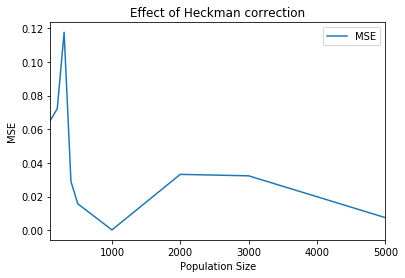

In [19]:
population_sizes = [100, 200, 300, 400, 500, 1000, 2000, 3000, 5000]
errors = [0] * len(population_sizes)

for i,ps in enumerate(population_sizes):
    e = heckman(N=ps, beta=[0.0, 1.0])
    errors[i] = e

pop_errors = pd.DataFrame({'Size' : population_sizes, 'MSE' : errors})
p = pop_errors.plot(x='Size', y='MSE')
p.set_title('Effect of Heckman correction')
p.set_xlabel('Population Size');
p.set_ylabel('MSE');

#### Questions

- How many samples needed in order to get an unbiased estimation of the parameters? 
- Is there any theoretical proof on that sample complexity?